In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble
import sklearn.impute
import sklearn.preprocessing
import sklearn.pipeline
import umap 

features = pd.read_pickle("../train_features.pkl")
labels = pd.read_csv("../train_labels.csv",index_col="challenge_oid")
features.index.name = "challenge_oid"
features_original = features.join(labels)
features_original = features_original[~pd.isna(features_original["classALeRCE"])]

features_test = pd.read_pickle("../test_features.pkl")
features_wise = pd.read_csv("../WISE_data_4_hackathon_with_IDs.csv")

#join wise with train
#features_original = features_original.join(features_wise)#, on="challenge_oid")
#features_test = features_test.join(features_wise)#, on="challenge_oid")
#join wise with test

In [30]:
preprocess_pipeline = sklearn.pipeline.make_pipeline(
    sklearn.impute.SimpleImputer(strategy="median"),
    sklearn.preprocessing.MinMaxScaler(),
    umap.UMAP(n_components=10),
)
train_data = features.join(labels)
label_encoder = sklearn.preprocessing.LabelEncoder()
num_labels = label_encoder.fit_transform(train_data["classALeRCE"])
preprocess_pipeline.fit(train_data.drop("classALeRCE", axis=1), num_labels)

C:\Users\Alexis\Anaconda3\envs\ds\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\..\Anaconda3\envs\ds\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('umap',
                 UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
                      learning_rate=1.0, local_connectivity=1.0,
                      metric='euclidean', metric_kwds=None, min_dist=0.1,
                      n_components=10, n_epochs=None, n_neighbors=15,
                      negative_sample_rate=5, random_state=None,
                      repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
                      target_metric='categorical', target_metric_kwds=None,
                      target_n_neighbors=-1, target_weight=0.5,
                      transform_queue_size=4.0, transform_seed=42,
   

In [31]:
transformed_train = preprocess_pipeline.transform(train_data.drop("classALeRCE", axis=1))
transformed_test = preprocess_pipeline.transform(features_test)

C:\Users\Alexis\Anaconda3\envs\ds\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\..\Anaconda3\envs\ds\lib\site-packages\umap\nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
C:\Users\Alexis\Anaconda3\envs\ds\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\..\Anaconda3\envs\ds\lib\site-packages\

In [32]:
isolation_forest = sklearn.ensemble.IsolationForest(n_estimators=400, n_jobs=-1)
isolation_forest.fit(transformed_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=400,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

Text(0.5, 1.0, 'outliers score minmax')

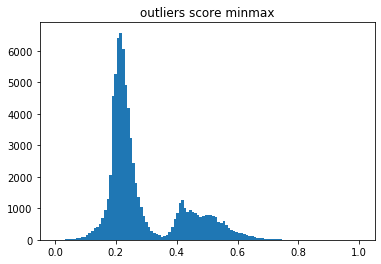

In [44]:
if_out = isolation_forest.predict(transformed_test)
scores = isolation_forest.score_samples(transformed_test)
norm_scores = sklearn.preprocessing.MinMaxScaler().fit_transform(-scores.reshape(-1, 1))
_ = plt.hist(norm_scores, bins="auto")
plt.title("outliers score minmax")

In [62]:
outlier_df = pd.DataFrame(1.2*norm_scores, columns=["Outlier"])#
outlier_df["challenge_oid"] = features_test.index
outlier_df.to_csv("outliers_if.csv", index=False)

In [63]:
if_out_train = isolation_forest.predict(transformed_train)
train_scores = isolation_forest.score_samples(transformed_train)
norm_train_scores = sklearn.preprocessing.MinMaxScaler().fit_transform(-train_scores.reshape(-1, 1))

Text(0.5, 1.0, 'outlier in train set')

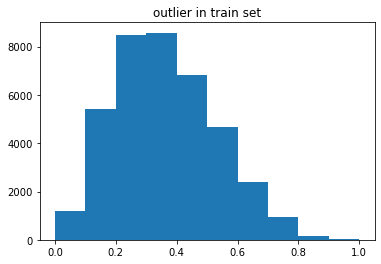

In [64]:
_ = plt.hist(norm_train_scores)
plt.title("outlier in train set")

In [65]:
dec_function = isolation_forest.decision_function(transformed_test)
original_paper_score = np.array([-1*s + 0.5 for s in dec_function])

outlier_df_scores = pd.DataFrame(1.1*original_paper_score, columns=["Outlier"])#
outlier_df_scores["challenge_oid"] = features_test.index
outlier_df_scores.to_csv("outliers_new.csv", index=False)

Text(0.5, 1.0, 'outliers scores -modified-')

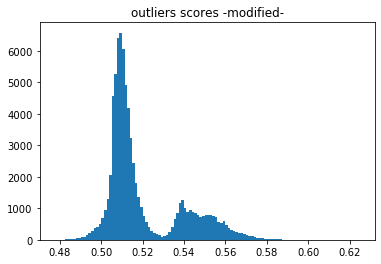

In [66]:
_ = plt.hist(1.1*np.array(original_paper_score), bins="auto")
plt.title("outliers scores -modified-")

In [67]:
np.array(original_paper_score)

array([0.50511158, 0.50558042, 0.47016437, ..., 0.46272114, 0.46285586,
       0.46729569])